Датафрейм: weatherHistory.csv. Примеры аналитических задач:
- провести анализ переменных, определить их влияние друг на друга;
- обучить модель для предсказания температуры (временной ряд);
- обучить модель для предсказания осадков (классификация).

Импортируем нужные для анализа и исследования библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as sm
import warnings
warnings.filterwarnings("ignore")
from dateutil.parser import parse
import seaborn as sns
import statsmodels.formula.api as sm

Считаем датасет и просмотрим его

In [ ]:
df = pd.read_csv('/content/weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Приведем датасет в порядок, просмотрим на типы данных, пропуски, категориальные значения, дубликаты и т.д.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


Числовые данные не являются строками - уже хорошо

In [ ]:
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


Видим, что столбец "Loud Cover" полностью состоит из нулевых значений, его смело можно будет удалить, также распределение скорости ветра весьма показательно, первые 2 квантиля находятся в пределах от 0 до 10 км/ч, а максимальное значение достигает аж 63 км/ч, насколько эти данные считать выбросы - решим позже


In [ ]:
del df["Loud Cover"]

In [ ]:
(df.isnull().sum()/df.shape[0])*100

Formatted Date              0.000000
Summary                     0.000000
Precip Type                 0.536012
Temperature (C)             0.000000
Apparent Temperature (C)    0.000000
Humidity                    0.000000
Wind Speed (km/h)           0.000000
Wind Bearing (degrees)      0.000000
Visibility (km)             0.000000
Pressure (millibars)        0.000000
Daily Summary               0.000000
dtype: float64

Нулевые значения есть только в столбце "Precip Type" - их достаточно мало, посмотрим на распределение этого столбца

In [ ]:
df["Precip Type"].value_counts()

rain    85224
snow    10712
Name: Precip Type, dtype: int64

Либо дождь, либо снег, давайте придадим какое - то значение этим пропускам, может это солнечная погода

In [ ]:
df["Precip Type"] = df["Precip Type"].fillna("None")
df[df["Precip Type"] == 'None']

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
52672,2012-04-11 16:00:00.000 +0200,Mostly Cloudy,None,19.016667,19.016667,0.26,14.8764,163.0,9.982,1002.40,Mostly cloudy until night.
52674,2012-04-11 18:00:00.000 +0200,Mostly Cloudy,None,17.850000,17.850000,0.28,13.7977,169.0,9.982,1001.79,Mostly cloudy until night.
52675,2012-04-11 19:00:00.000 +0200,Mostly Cloudy,None,16.322222,16.322222,0.32,10.8192,151.0,9.982,1001.60,Mostly cloudy until night.
52677,2012-04-11 21:00:00.000 +0200,Mostly Cloudy,None,12.566667,12.566667,0.43,9.0160,159.0,9.982,1001.92,Mostly cloudy until night.
52678,2012-04-11 22:00:00.000 +0200,Mostly Cloudy,None,12.927778,12.927778,0.47,17.6295,197.0,16.100,1002.20,Mostly cloudy until night.
...,...,...,...,...,...,...,...,...,...,...,...
95584,2016-10-31 19:00:00.000 +0100,Mostly Cloudy,None,8.322222,7.044444,0.85,8.0339,290.0,0.000,1021.73,Mostly cloudy starting in the afternoon.
95585,2016-10-31 20:00:00.000 +0100,Mostly Cloudy,None,7.627778,6.183333,0.87,8.2271,293.0,0.000,1021.76,Mostly cloudy starting in the afternoon.
95586,2016-10-31 21:00:00.000 +0100,Mostly Cloudy,None,7.111111,5.511111,0.89,8.5008,297.0,0.000,1021.81,Mostly cloudy starting in the afternoon.
95587,2016-10-31 22:00:00.000 +0100,Partly Cloudy,None,6.672222,4.961111,0.90,8.6457,299.0,0.000,1021.83,Mostly cloudy starting in the afternoon.


In [ ]:
df[df["Precip Type"] == 'None'].describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,10.393015,9.462841,0.745667,11.869188,185.738878,7.549499,1019.179188
std,4.585832,5.405954,0.141009,5.324879,107.114929,6.185008,8.893669
min,1.255556,-0.822222,0.260000,1.078700,0.000000,0.000000,993.940000
25%,7.105556,5.072222,0.660000,7.695800,123.000000,0.000000,1016.650000
50%,9.988889,9.194444,0.770000,11.640300,164.000000,9.982000,1021.160000
75%,12.961111,12.961111,0.850000,14.876400,293.000000,11.157300,1024.480000
max,25.044444,25.044444,1.000000,29.881600,359.000000,16.100000,1034.500000


In [ ]:
df[df["Precip Type"] != 'None'].describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000
mean,11.940976,10.862531,0.734841,10.804936,187.518773,10.362402,1003.150038
std,9.570671,10.717812,0.195724,6.920727,107.385351,4.173780,117.276976
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.604167,2.276389,0.600000,5.796000,116.000000,8.372000,1011.890000
50%,12.033333,12.033333,0.780000,9.933700,180.000000,10.046400,1016.420000
75%,18.844444,18.844444,0.890000,14.135800,290.000000,14.812000,1021.050000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000


Уже зная, что в столбце с типом погоды у нас дождь или снег, то неизвестные данные не сильно увеличивают температуру и нельзя сказать, что это данные о солнечных или теплых днях, эти данные занимают 0.5% данных, поэтому их удаление не должно сказаться на датасете

In [ ]:
df = pd.read_csv('/content/weatherHistory.csv')
df.dropna(inplace=True)

In [ ]:
sum(df.duplicated())

24

In [ ]:
df[df.duplicated()]

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
36072,2010-08-02 00:00:00.000 +0200,Clear,rain,18.800000,18.800000,0.93,6.2790,270.0,14.9086,0.0,1016.99,Partly cloudy starting in the afternoon contin...
36073,2010-08-02 01:00:00.000 +0200,Clear,rain,18.222222,18.222222,0.97,6.2790,291.0,14.9086,0.0,1017.09,Partly cloudy starting in the afternoon contin...
36074,2010-08-02 02:00:00.000 +0200,Clear,rain,18.072222,18.072222,0.98,11.2700,290.0,6.8425,0.0,1013.23,Partly cloudy starting in the afternoon contin...
36075,2010-08-02 03:00:00.000 +0200,Clear,rain,16.622222,16.622222,0.99,6.4400,300.0,11.9784,0.0,1016.78,Partly cloudy starting in the afternoon contin...
36076,2010-08-02 04:00:00.000 +0200,Clear,rain,16.094444,16.094444,0.99,3.0751,280.0,11.9784,0.0,1016.67,Partly cloudy starting in the afternoon contin...
36077,2010-08-02 05:00:00.000 +0200,Clear,rain,15.955556,15.955556,0.99,3.8801,276.0,9.9820,0.0,1016.69,Partly cloudy starting in the afternoon contin...
36078,2010-08-02 06:00:00.000 +0200,Clear,rain,17.088889,17.088889,1.00,6.4400,310.0,9.9820,0.0,1017.08,Partly cloudy starting in the afternoon contin...
36079,2010-08-02 07:00:00.000 +0200,Clear,rain,20.822222,20.822222,0.87,3.2200,300.0,9.9820,0.0,1017.27,Partly cloudy starting in the afternoon contin...
36080,2010-08-02 08:00:00.000 +0200,Clear,rain,23.405556,23.405556,0.74,1.8837,334.0,9.9820,0.0,1017.27,Partly cloudy starting in the afternoon contin...
36081,2010-08-02 09:00:00.000 +0200,Clear,rain,26.050000,26.050000,0.59,1.5939,5.0,9.9820,0.0,1017.15,Partly cloudy starting in the afternoon contin...


Как видим данные от 02.08.2010 были продублированы, их также удалим

In [ ]:
df.drop_duplicates(inplace=True)

Отлично, немного привели данные в порядок, посмотрим на распределение двух других категориальных переменных, возможно они нам понадобятся

In [ ]:
df.value_counts('Summary')

Summary
Partly Cloudy                          31628
Mostly Cloudy                          27914
Overcast                               16516
Clear                                  10746
Foggy                                   7117
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Hu

In [ ]:
df.value_counts('Daily Summary')

Daily Summary
Mostly cloudy throughout the day.         20020
Partly cloudy throughout the day.          9930
Partly cloudy until night.                 6169
Partly cloudy starting in the morning.     5177
Foggy in the morning.                      4201
                                          ...  
Rain until afternoon.                        17
Rain until morning.                          12
Light rain in the morning.                   11
Drizzle starting in the evening.              9
Light rain overnight.                         3
Length: 214, dtype: int64

Как видим распределить краткое содержание погоды ещё можно будет, а разбивать 214 более полного содержания погоды уже проблематично, удалим их, чтобы не таскать лишные данные и объединим категориальные данные в один список

In [ ]:
del df['Daily Summary']

In [ ]:
del df["Loud Cover"]

In [ ]:
categorical_columns = ["Summary", "Precip Type"]

Самое время провести корреляцию между численными столбцами

<Axes: >

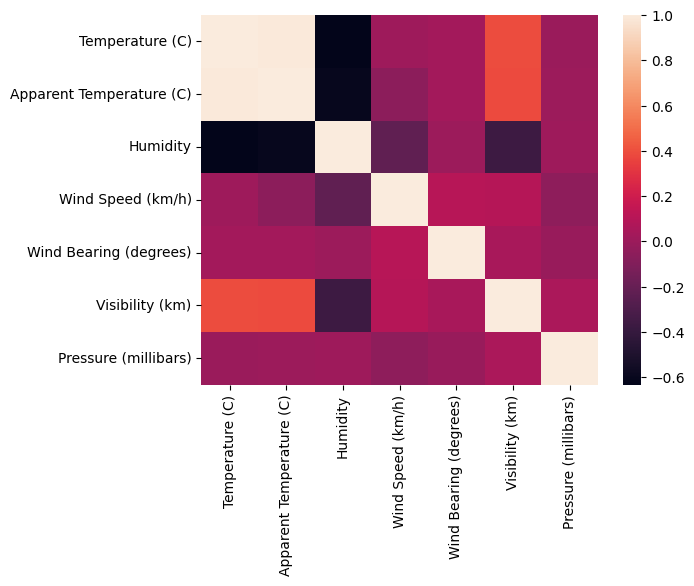

In [ ]:
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

* Влажность отрицательно связана с температурой
* Температура по ощущению и фактическая температура очень сильно связаны
* Видимость немного связана с фактической температурой

Немного визуализируем наши данные на небольшой выборке

In [ ]:
df_vis = df.sample(frac=0.2, replace=True, random_state=42)

In [ ]:
df.value_counts('Precip Type')

Precip Type
rain    85200
snow    10712
dtype: int64

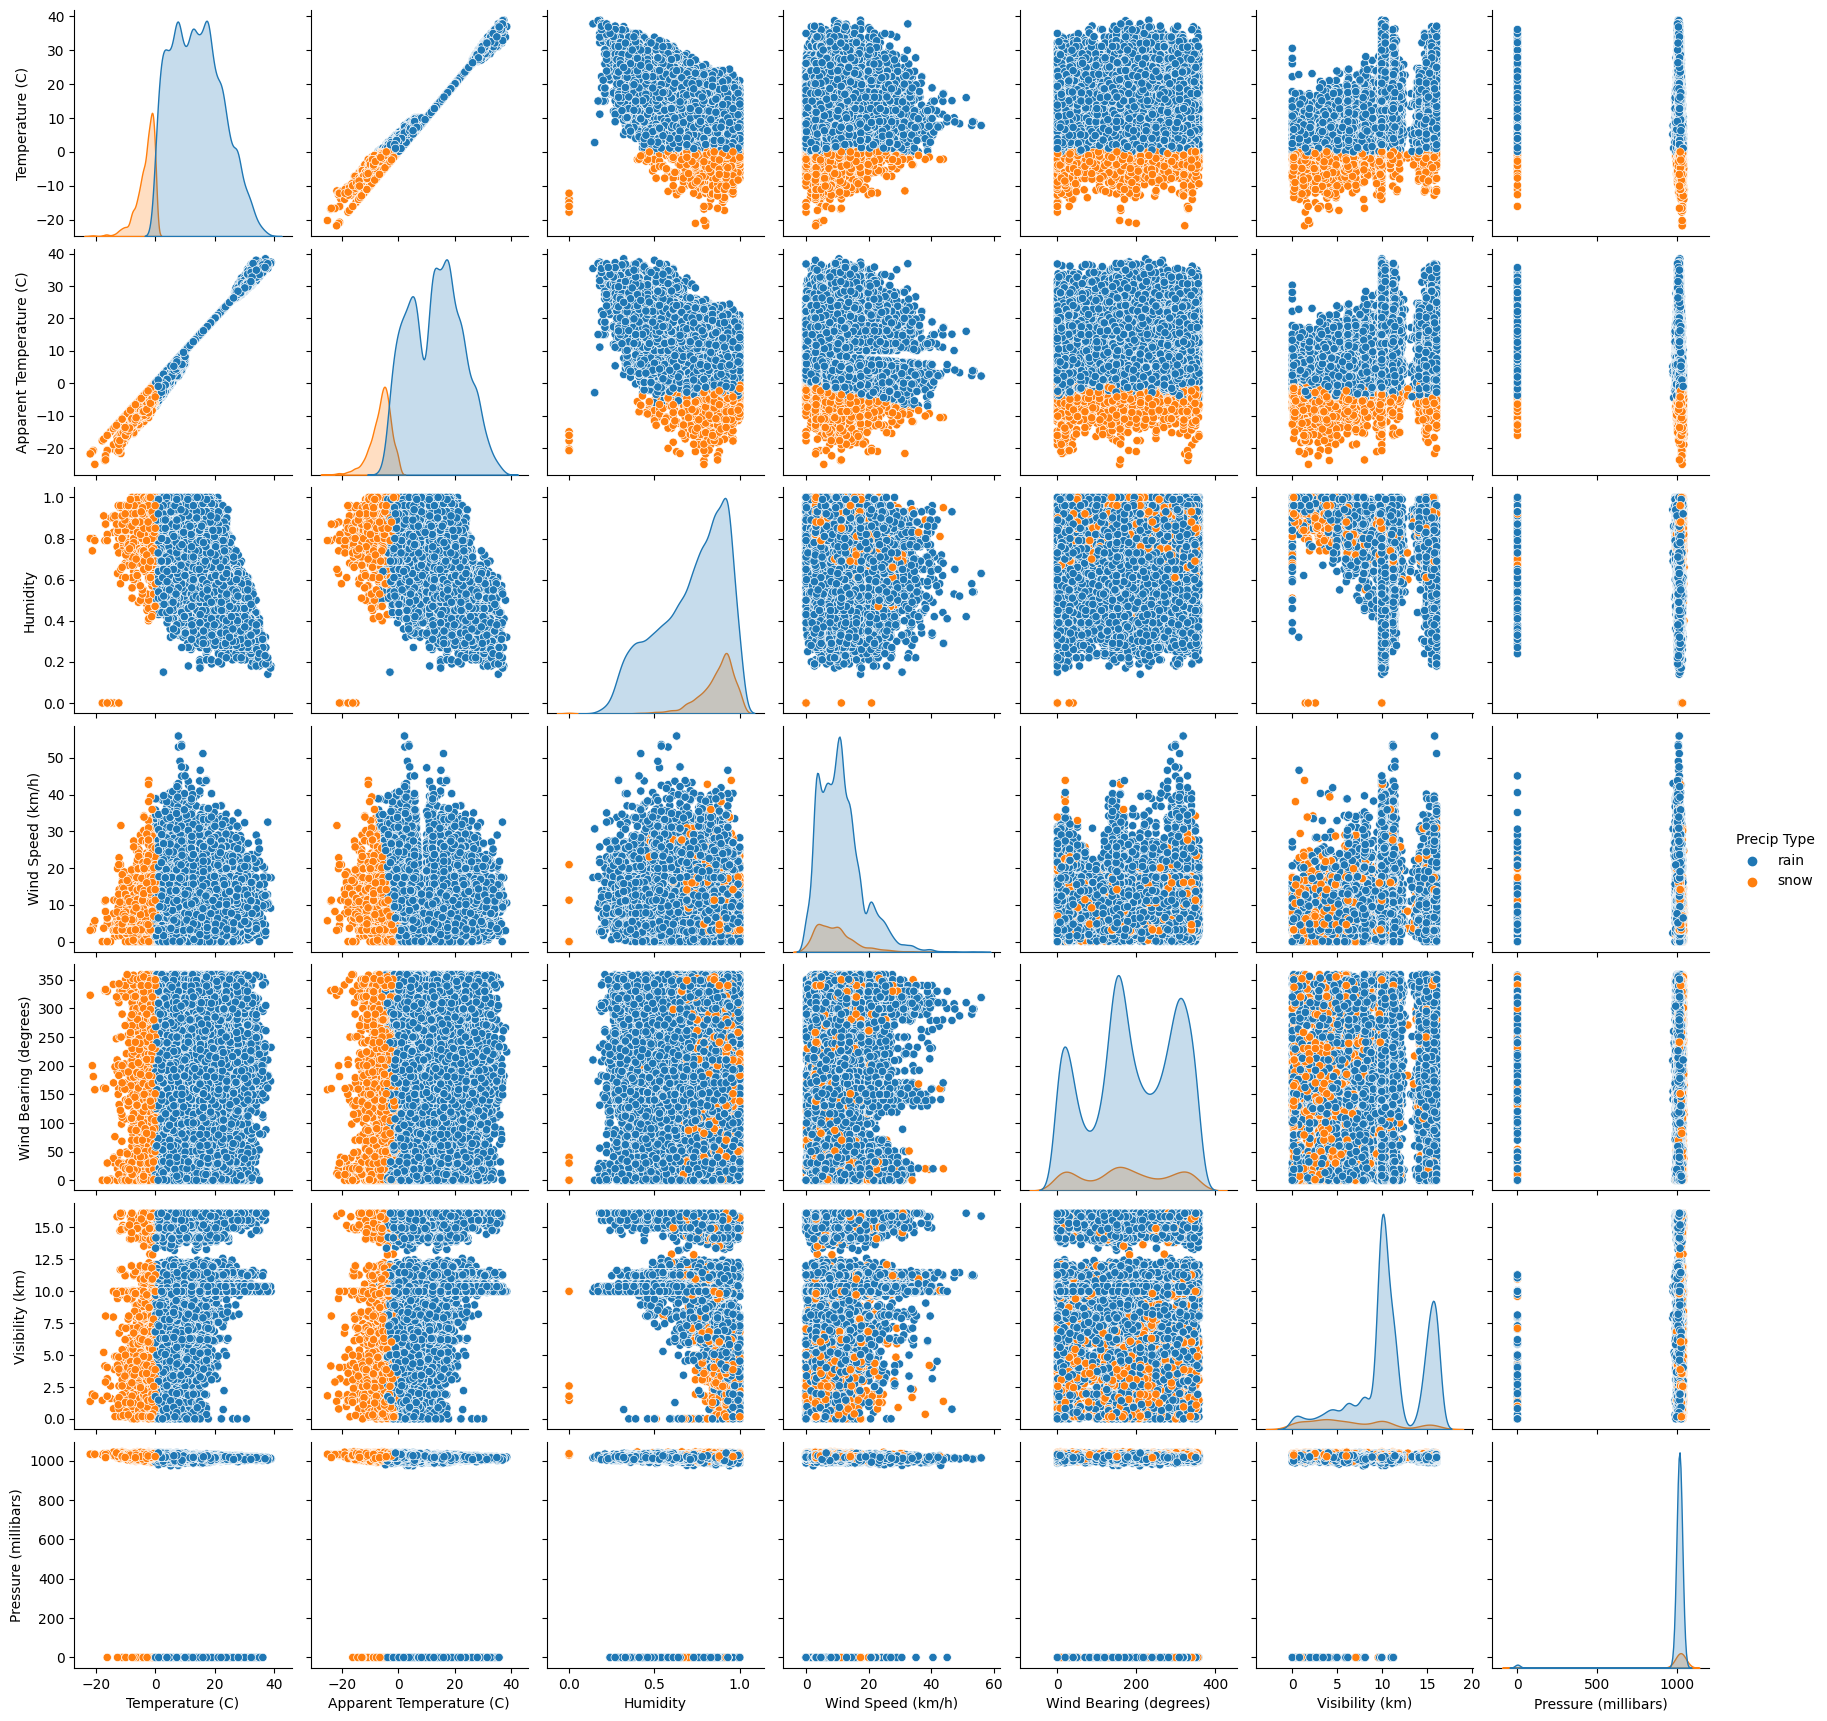

In [ ]:
sns.pairplot(data=df_vis, hue="Precip Type")

Данные подтверждают, что:

* При снеге более низкая температура
* При дожде более высокая температура


Перейдем к анализу и составлению регрессий, поставим несколько вопросов
# Существует ли какая-либо линейная зависимость между температурой и влажностью?
# Как влажность влияет на ощущаемую температуру?
Чтобы ответить на эти два вопроса, мы проведем ряд линейных регрессионных анализов:
- Первая регрессия (зависимая переменная: Температура и независимая переменная: Влажность)
- Вторая регрессия (Зависимая переменная : Влажность и независимая переменная : Температура)
- Третья регрессия (Зависимая переменная: Ощущаемая температура и независимая переменная : Влажность)
- Регрессия четвертая (Зависимая переменная: Ощущаемая температура и независимая переменная : Фактическая температура)
- Регрессия пятая (Зависимая переменная : Ощущаемая температура и независимая переменная: Влажность и температура)

In [ ]:
mod=sm.ols(formula='df["Temperature (C)"]~df["Humidity"]',data=df)
res=mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     df["Temperature (C)"]   R-squared:                       0.400
Model:                               OLS   Adj. R-squared:                  0.400
Method:                    Least Squares   F-statistic:                 6.386e+04
Date:                   Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                           14:54:18   Log-Likelihood:            -3.2825e+05
No. Observations:                  95912   AIC:                         6.565e+05
Df Residuals:                      95910   BIC:                         6.565e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [ ]:
mod=sm.ols(formula='df["Humidity"]~df["Temperature (C)"]',data=df)
res=mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         df["Humidity"]   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                 6.386e+04
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:54:38   Log-Likelihood:                 44822.
No. Observations:               95912   AIC:                        -8.964e+04
Df Residuals:                   95910   BIC:                        -8.962e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.88

In [ ]:
mod=sm.ols(formula='df["Apparent Temperature (C)"]~df["Humidity"]',data=df)
res=mod.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     df["Apparent Temperature (C)"]   R-squared:                       0.363
Model:                                        OLS   Adj. R-squared:                  0.363
Method:                             Least Squares   F-statistic:                 5.465e+04
Date:                            Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                                    14:55:00   Log-Likelihood:            -3.4195e+05
No. Observations:                           95912   AIC:                         6.839e+05
Df Residuals:                               95910   BIC:                         6.839e+05
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------

In [ ]:
mod=sm.ols(formula='df["Apparent Temperature (C)"]~df["Temperature (C)"]',data=df)
res=mod.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     df["Apparent Temperature (C)"]   R-squared:                       0.985
Model:                                        OLS   Adj. R-squared:                  0.985
Method:                             Least Squares   F-statistic:                 6.439e+06
Date:                            Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                                    14:55:12   Log-Likelihood:            -1.6113e+05
No. Observations:                           95912   AIC:                         3.223e+05
Df Residuals:                               95910   BIC:                         3.223e+05
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]


In [ ]:
mod=sm.ols(formula='df["Apparent Temperature (C)"]~df[["Temperature (C)","Humidity"]]',data=df)
res=mod.fit()
print(res.summary())

                                  OLS Regression Results                                  
Dep. Variable:     df["Apparent Temperature (C)"]   R-squared:                       0.986
Model:                                        OLS   Adj. R-squared:                  0.986
Method:                             Least Squares   F-statistic:                 3.471e+06
Date:                            Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                                    14:55:24   Log-Likelihood:            -1.5757e+05
No. Observations:                           95912   AIC:                         3.152e+05
Df Residuals:                               95909   BIC:                         3.152e+05
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
                                             coef    std err          t      P>|t|      [0

 Мы обнаружили, что существует взаимосвязь между влажностью и фактической температурой, но квадрат отклонений достаточно низок (0,4), также как и ощущаемой температурой и влажностью, коэффициент всего 0,363, но когда мы рассматриваем температуру как независимую переменную для ощущаемой температуры, тогда значение R-квадрата увеличивается (0,985)
 Вероятно это связано с тем, что температура, которую мы ощущаем - это комбинация влажности и реальной температуры, а они влияют друг на друга, как выяснили выше.